# 6.1 파이프라인을 사용한 효율적인 워크플로
## 6.1.1 위스콘신 유방암 데이터셋



In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)


In [41]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                 header=None)

# df = pd.read_csv('your/local/path/to/wdbc.data',
#                  header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_


array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])


array([1, 0])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)


## 6.1.2 파이프라인으로 변환기와 추정기 연결

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))


테스트 정확도: 0.956


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 파이프라인 정의
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))

from sklearn import set_config
set_config(display='diagram')

# 파이프라인 출력
pipe


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

# 6.2 k-겹 교차 검증을 사용한 모델 성능 평가

### 6.2.1 홀드아웃 방법
### 6.2.2 k-겹 교차 검증

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))


폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [8]:
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))



CV 정확도: 0.950 +/- 0.014


In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [10]:
from sklearn.model_selection import cross_validate
scores = cross_validate(estimator=pipe_lr, X=X_train, y=y_train, scoring=['accuracy'], cv=10, n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))


CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [11]:
from sklearn.model_selection import cross_val_predict
preds = cross_val_predict(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
preds[:10]


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [12]:
from sklearn.model_selection import cross_val_predict
preds = cross_val_predict(estimator=pipe_lr, X=X_train, y=y_train, cv=10, method='predict_proba', n_jobs=-1)
preds[:10]


array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

# 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석

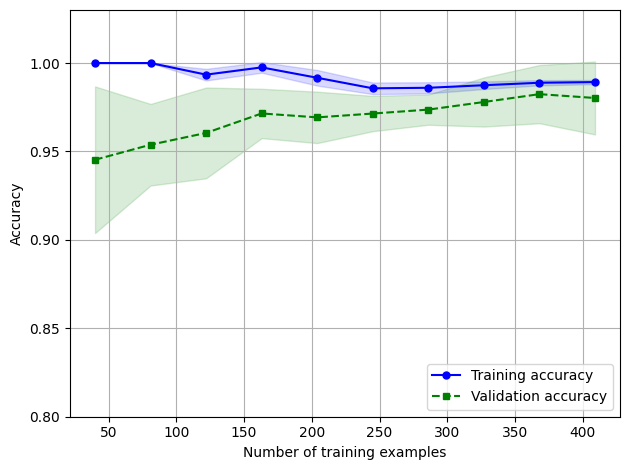

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사

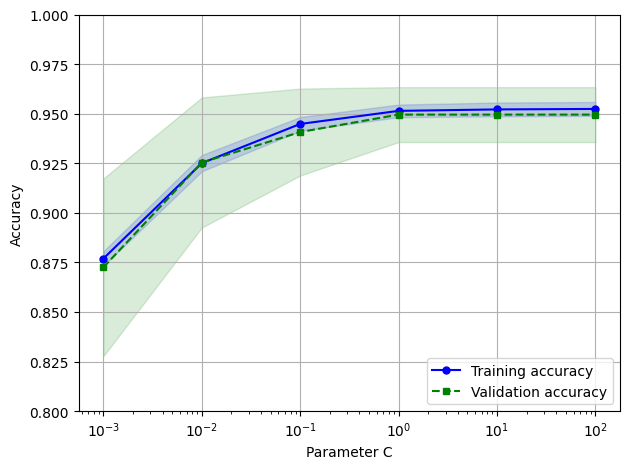

In [45]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()


# 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

### 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)


0.9846859903381642


In [48]:
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))


{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
테스트 정확도: 0.974


In [49]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, return_train_score=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']


array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [50]:
gs.cv_results_['mean_train_score']


array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [51]:
gs.cv_results_['split0_test_score']


array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [52]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))


테스트 정확도: 0.974


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
distribution = loguniform(0.0001, 1000.0)
param_dist = [{'svc__C': distribution, 'svc__kernel': ['linear']}, {'svc__C': distribution, 'svc__gamma': distribution, 'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_dist, n_iter=30, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)


0.9824637681159419
{'svc__C': 210.66440708362174, 'svc__gamma': 0.0006861724481510377, 'svc__kernel': 'rbf'}


In [53]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
hgs = HalvingGridSearchCV(estimator=pipe_svc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)
hgs = hgs.fit(X_train, y_train)
print(hgs.best_score_)
print(hgs.best_params_)


n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 455
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 40
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 120
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 360
Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.9802380952380952
{'svc__C': 1000.0, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [54]:
print(np.sum(hgs.cv_results_['mean_fit_time']))
print('자원 리스트:', hgs.n_resources_)
print('후보 리스트:', hgs.n_candidates_)


0.5797996520996094
자원 리스트: [40, 120, 360]
후보 리스트: [72, 24, 8]


### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택

In [55]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV 정확도: 0.974 +/- 0.015


In [56]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV 정확도: 0.934 +/- 0.016


# 6.5 여러가지 성능 평가 지표

## 6.5.1. 오차행렬

In [26]:
# 6.5.1
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


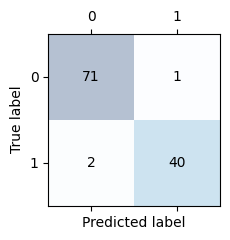

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


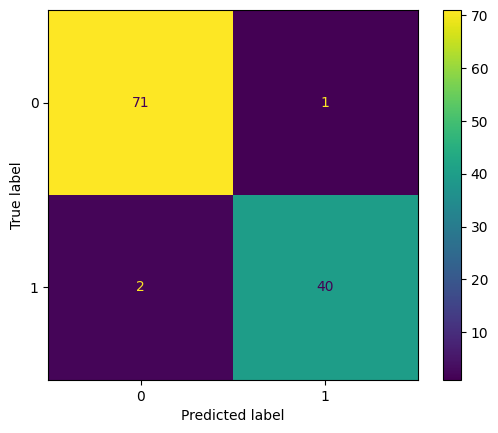

In [70]:
# from sklearn.metrics import ConfusionMatrixDisplay
# plot_confusion_matrix(pipe_svc, X_test, y_test)
# plt.show()
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 데이터 로드 및 전처리
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# 파이프라인 정의 및 학습
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.fit(X_train, y_train)

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()


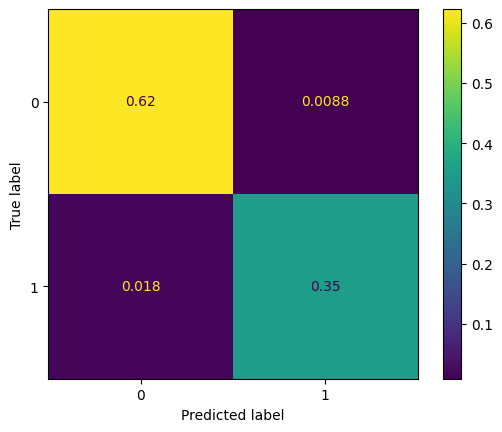

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# 파이프라인 정의 및 학습
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.fit(X_train, y_train)

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, normalize='all')  # 변경된 부분
plt.show()


### 6.5.2 분류 모델의 정밀도와 재현율 최적화

In [30]:
#6.5.2
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


정밀도: 0.976
재현율: 0.952
F1: 0.964


In [31]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']}, {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### 6.5.3 ROC 곡선 그리기

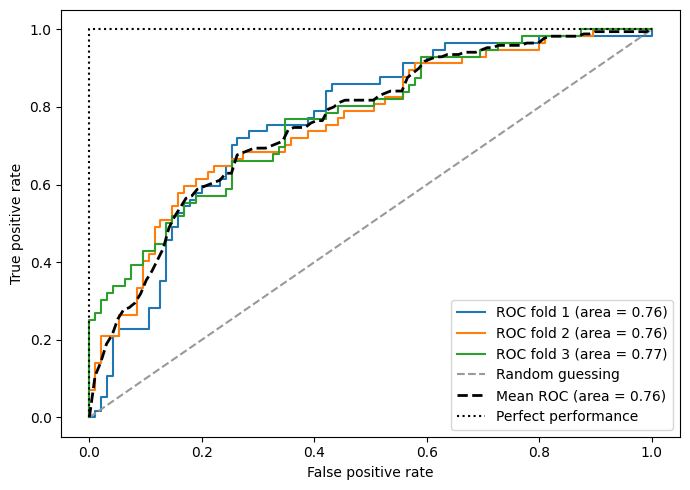

In [32]:
#6.5.3
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


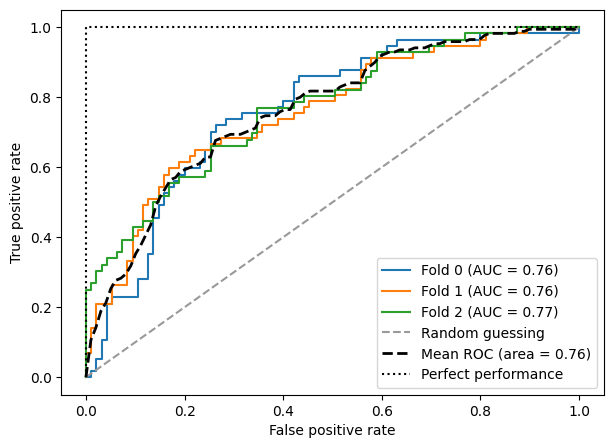

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# 필요한 특징 선택
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

# 파이프라인 정의
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))

# StratifiedKFold 설정
cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

fig, ax = plt.subplots(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = RocCurveDisplay.from_estimator(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_tpr += np.interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


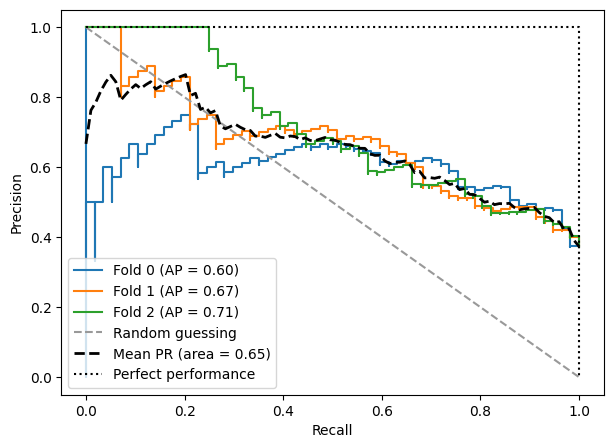

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# 필요한 특징 선택
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

# 파이프라인 정의
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))

# StratifiedKFold 설정
cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

fig, ax = plt.subplots(figsize=(7, 5))
mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = PrecisionRecallDisplay.from_estimator(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_precision += np.interp(mean_recall, pr_disp.recall[::-1], pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--', label=f'Mean PR (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 1, 1], [1, 1, 0], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()


### 6.5.4 다중 분류의 성능 지표

In [88]:
#6.5.4
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')


# 6.6 불균형한 클래스 다루기

In [36]:
#6.6
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))


In [37]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100


89.92443324937027

In [38]:
from sklearn.utils import resample
print('샘플링하기 전 클래스 1 의 샘플 개수:', X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)
print('샘플링한 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])


샘플링하기 전 클래스 1 의 샘플 개수: 40
샘플링한 후 클래스 1의 샘플 개수: 357


In [39]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))


In [40]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100


50.0